In [1]:
import numpy as np

# Question 1

## 1a)

The price process of the risky asset $S^n = \{S^n_0, \ldots, S^n_n\}$ is such that $S^n_j = S_0\exp\left(jb_n + \sigma_n\sum_{l=1}^j Z_l \right)$ at time $j$, where the $Z_l$ are such that
$$
    \mathbb P[Z_l = -1] = \mathbb P[Z_l = 1] = 1/2.
$$

Thus, in the definition $S^n_j(i) = S_0u^{j-i}d^i = S_0\exp\left(jb_n + \sigma_n(j - 2i)\right)$, $i$ is the number of $l\in\{0,\ldots,j\}$ such that $Z_l = -1$.

In [2]:
S0 = 100
sigma = 0.3
r = b = 0.05
T = 2
n = 50

def udcoeffs(T, n, b, sigma):
    hn = T/n
    u = np.exp(b*hn + sigma*np.sqrt(hn))
    d = np.exp(b*hn - sigma*np.sqrt(hn))
    return u,d


def Sn(S, T, n, b, sigma, j):
    """
    Vector of all possible prices for the option of maturity T, at time j.
    """
    u, d = udcoeffs(T, n, b, sigma)
    indices = np.arange(0, j+1)
    return S*np.power(u, j-indices)*np.power(d, indices)

j = 5
snj = Sn(S0, T, n, b, sigma, j)
print(snj)

[136.34251141 120.92495977 107.25081813  95.12294245  84.36648166
  74.82635676]


## 1b)

In [3]:
def Payoffn(S, T, n, b, sigma, K):
    """
    Compute the Payoff of an European call option with maturity T,
    and strike K.
    """
    ## current time is maturity, j=n
    snT = Sn(S, T, n, b, sigma, n)
    delta = snT - K
    vals = np.stack([delta, np.zeros_like(delta)])
    return np.max(vals, 0) # Maximum selon la première dimension, donc les valeurs max(snT-K, 0)

K = 80
Payoffn(S0, T, n, b, sigma, K)

array([2139.79512814, 1888.78166448, 1666.15269366, 1468.69850963,
       1293.57235851, 1138.24939607, 1000.49028639,  878.30891668,
        769.94376289,  673.83249337,  588.58944423,  512.98564186,
        445.93108444,  386.4590271 ,  333.71204403,  286.92966676,
        245.43742029,  208.63709893,  175.99814183,  147.04998375,
        121.37527075,   98.60384308,   78.4073985 ,   60.49475906,
         44.60767306,   30.51709181,   18.01986733,    6.93582354,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ])

## 1c)

Let $N = \sum_l \frac{1+Z_l}{2}\in\{0,\ldots,j\}$ be the number of $l\in\{0,\ldots,n\}$ such that $Z_l = -1$. It follows the binomial distribution $\mathcal B(n,1/2)$ for the standard probability law $\mathbb P$.

Under the no-risk probability $\mathbb Q_n$ and conditionally to the knowledge of the price process up to time $j=k$, we have $S^n_{k+1} = u S^n_{k}$ with probability $q_n$ because it is exactly the probability that $Z_n = 1$. Conversely
$$
    \mathbb Q_n \left[ S^n_{k+1} = d S^n_{k} \,|\, \mathcal F^n_{k} \right] = 1-q_n.
$$
The variable $N$ follows the binomial law $\mathcal B(n, 1-q_n)$ under $\mathbb Q_n$.

Thus,
$$
    \mathbb E^{\mathbb Q_n}_{k}\left[ B^n_{k+1} \right] = q_n(u S^n_{k} - K)^+ + (1 - q_n)(dS^n_{k} - K)^+
$$

In particular, the call option price is given by the total expectation
$$
    C = e^{-rT}\mathbb E^{\mathbb Q_n}\left[ \left(S_n^n - K\right)^+ \right] = e^{-rT} \mathbb B\cdot\verb|payoff(T, n, b, sigma, K)|
$$
where the vector $\mathbb B = \left\{\mathbb Q_n\left(N=i\right)\right\}_i$

In [4]:
import scipy.stats

def Calln(S, T, n, r, b, sigma, K):
    """
    Compute the price of an European call option
    """
    # Price process at current time j
    u, d = udcoeffs(T, n, b, sigma)
    hn = T/n
    rn = np.exp(r*hn)
    # Risk neutral probability
    qn = (rn - d)/(u - d)

    dist = scipy.stats.binom(n, 1-qn)
    # Vector BB of Q_n(N = i)
    weights = dist.pmf(np.arange(0, n+1))

    payoff = Payoffn(S, T, n, b, sigma, K)
    # Price is the adjusted expected value of the payoff
    # weighted by the binomial distribution B(n, qn)
    p = np.vdot(weights, payoff)
    
    return np.exp(-r*T)*p

Calln(S0, T, n, r, b, sigma, K)

32.221526948181946

## 1d)

In [5]:
def Deltan(S, T, n, r, b, sigma, K, j):
    """
    
    """
    assert j <= n
    # Price process at current time j
    snj  = Sn(S, T, n, b, sigma, j)
    # next expected prices
    snj1 = Sn(S, T, n, b, sigma, j+1)
    u, d = udcoeffs(T, n, b, sigma)

    # Compute the call prices for every price instante in the future
    calls_new_ = [Calln(S, T, n, r, b, sigma, K) for S in snj1]
    
    thetnj = [
        (calls_new_[i] - calls_new_[i+1])/(u*snj[i] - d*snj[i]) for i in range(j+1)
    ]
    return thetnj

In [6]:
Deltan(S0, T, n, r, b, sigma, K, 10)

[0.9925714973116623,
 0.9842257355689848,
 0.9689734730219524,
 0.9432975564674919,
 0.9034223327493968,
 0.8462219583247668,
 0.7703593316512088,
 0.6772711698810366,
 0.5715411791255111,
 0.46035838068566004,
 0.35211237534597517]

In [7]:
import matplotlib.pyplot as plt

Text(0.5,1,'Price $C$ of the European call option\nas a function of strike $K$')

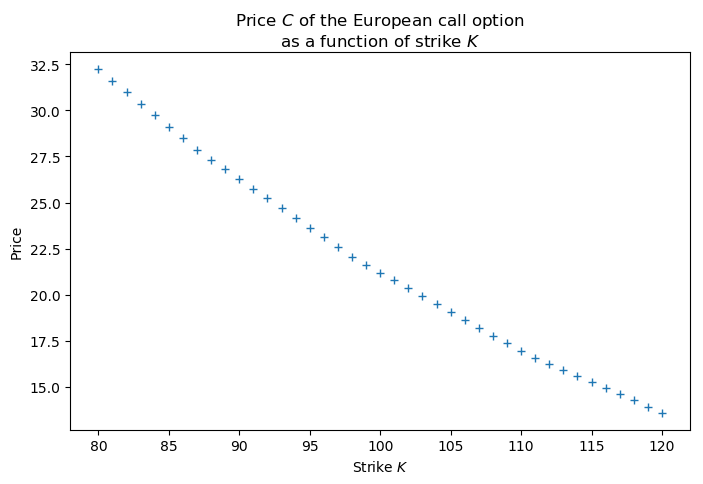

In [8]:
sigma = 0.3
r = b = 0.05
n = 50
K_values = [80+i for i in range(41)]
call_values = [Calln(S0, T, n, r, b, sigma, K) for K in K_values]

plt.figure(figsize=(8,5), dpi=100)
plt.plot(K_values, call_values, '+')
plt.xlabel("Strike $K$")
plt.ylabel("Price")
plt.title("Price $C$ of the European call option\nas a function of strike $K$")

The option price for the European call option is convex and decreasing in the strike $K$, as expected as per the properties of such call options.

Text(0.5,1,'Optimal hedge at time $j=0$\nas function of strike $K$')

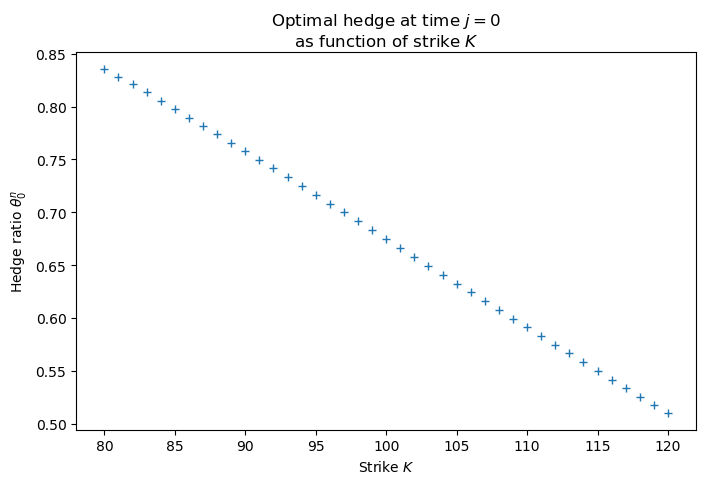

In [9]:
start_hedges_ = [Deltan(S0, T, n, r, b, sigma, K, 0)[0] for K in K_values]

plt.figure(figsize=(8,5), dpi=100)
plt.plot(K_values, start_hedges_, '+')
plt.xlabel("Strike $K$")
plt.ylabel(r"Hedge ratio $\theta_0^n$")
plt.title("Optimal hedge at time $j=0$\nas function of strike $K$")

The starting optimal hedge ratio $\theta^n_0$ is decreasing with respect to the strike $K$. (The same can be said of the ratio at other times since we can take any time $j$ as a starting point). This behaviour is somewhat expected: the higher the strike, the more likely the option will have zero return and we will lose money: the optimal hedging strategy to cover that risk will contain less of the asset.

# Question 2

## 2a)

In the Black-Scholes model, the price at $t=0$ of a maturity $T$ and strike $K$ call option is given by
$$
    C = S\,\mathrm{erf}(d_+) - K\exp(-rT)\,\mathrm{erf}(d_-)
$$

where $\mathrm{erf}$ is the normal distribution's cumulative density function, and 
$$
    d_{\pm} = \frac{\ln\left(Se^{rT}/K\right)}{\sigma\sqrt T} \pm \frac{\sigma\sqrt T}{2}
$$

In [10]:
def dplusminus_(s, k, v):
    base = np.log(s/k)/np.sqrt(v)
    vari = np.sqrt(v)/2
    return (base-vari, base+vari)

def CallBS(S, T, r, sigma, K):
    dm, dp = dplusminus_(S, K*np.exp(-r*T), sigma*sigma*T)
    return S*scipy.stats.norm.cdf(dp) - K*np.exp(-r*T)*scipy.stats.norm.cdf(dm)

In [11]:
K = 80
CallBS(S0, T, r, sigma, K)

32.19291006531836

In [12]:
def err(S, T, n, r, sigma, K):
    return Calln(S, T, n, r, b, sigma, K)/CallBS(S, T, r, sigma, K) - 1

Text(0.5,0,'CRR time sample size $n$')

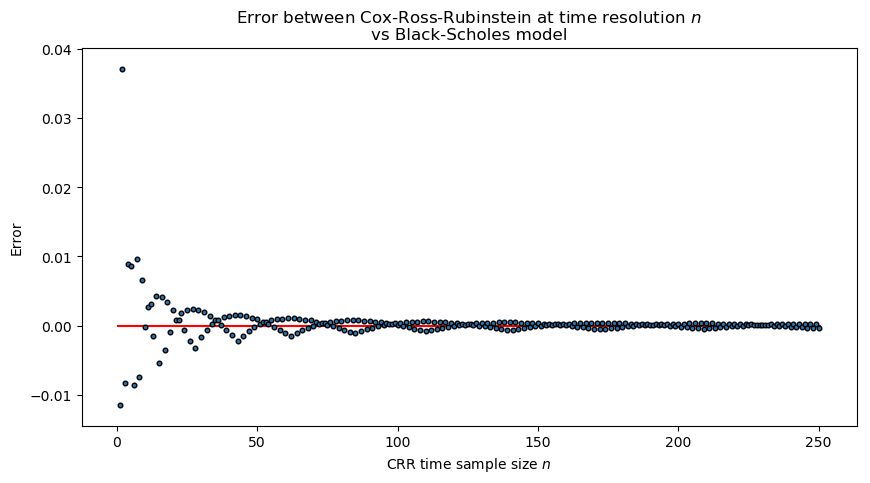

In [13]:
Nmax = 250
error_estimates_ = [err(S0, T, ns, r, sigma, K) for ns in range(1, Nmax+1)]
plt.figure(figsize=(10,5), dpi=100)
plt.title("Error between Cox-Ross-Rubinstein at time resolution $n$\nvs Black-Scholes model")
plt.hlines(0, 0, Nmax+1, 'r', zorder=-1)
plt.scatter(np.arange(1, Nmax+1), error_estimates_, edgecolors='k', s=11)
plt.ylabel('Error')
plt.xlabel('CRR time sample size $n$')

We observe very rapid convergence of the error towards zero (consistently below 0.5% by $n=100$): we can conclude that the Cox-Ross-Rubinstein models converges towards Black-Scholes at reasonable speed.